# LAB 4: Electrocardiograms and Neural Networks

In this lab, we will predict heart arrhythmia using LSTMs and 1-D CNNs.

We will work with the **St. Petersburg INCART 12-lead Arrhythmia Database** ([link](https://physionet.org/static/published-projects/incartdb/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0.zip)).  
The dataset contains **12-lead ECG recordings** sampled at **257 Hz** from 75 subjects, annotated by experts for arrhythmia detection.

---

### **Important Notes:**

1. **GPU Requirement:**  
   - A GPU is required for this lab.  
   - Please request GPU source on Rockfish.

2. **Memory Management:**  
   - If you encounter **RAM/memory overflow** issues, ensure that you **train only one model per session**.  
   - Feel free to apply **custom memory optimization techniques** to manage resource usage effectively.

---

In [2]:
# Install the package you need for this lab
%pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Feel free to add more libraries if you need them
import os
import wfdb
import numpy as np
import pandas as pd
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal
import zipfile
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score,f1_score
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Please remain this random seed unchange for your work's evaluation
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [4]:
# Load database
dataset_url = "https://physionet.org/static/published-projects/incartdb/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0.zip"
dataset_zip_path = "incartdb.zip"
dataset_extract_path = "incartdb_dataset"
if not os.path.exists(dataset_zip_path):
    print("Downloading INCART 12-lead Arrhythmia Database...")
    urllib.request.urlretrieve(dataset_url, dataset_zip_path)
    print("Download completed.")
if not os.path.exists(dataset_extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
        zip_ref.extractall(dataset_extract_path)
    print("Extraction completed.")

## Explore database

We will primarily use \<patientID>.atr files (patientID being I01, I02, etc.). There are 75 patients with 30-minute recordings each.

For patient 'I48', let's check their signal annotations. Run the code below.

In [94]:
# We provide function for loading an ECG file
def load_ECG_file(path):
    '''
    Input:
        path: Path to the patient file (excluding the extension)
    Output:
        signal: ECG signal (lead I by default)
        symbol: Annotation symbols (heartbeat types)
        index: Annotation indices (sample positions of heartbeats)
    '''
    record = wfdb.rdrecord(path)  # Load ECG signal
    annotation = wfdb.rdann(path, 'atr')  # Load annotations

    signal = record.p_signal[:, 0]  # Select lead I (first lead)
    symbol = annotation.symbol  # Extract annotation symbols
    index = annotation.sample  # Extract annotation indices

    return signal, symbol, index
path_dataset = '/home/en520-jyu146/incartdb_dataset/files/'
signal, symbol, index = load_ECG_file(os.path.join(path_dataset, 'I48'))
print(f'Length of signal: {len(signal)}')  # Length of ECG signal (in samples)
print(f'Annotation symbols (first 10): {symbol[:100]}')  # First 100 annotation symbols
print(f'Annotation indices (first 10): {index[:100]}')  # First 100 annotation indices

Length of signal: 462600
Annotation symbols (first 10): ['N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Annotation indices (first 10): [  209   446   676   906  1102  1231  1555  1778  1979  2110  2339  2528
  2740  2873  3158  3361  3542  3676  3892  4071  4287  4487  4695  4881
  5059  5256  5480  5617  5900  6073  6281  6415  6711  6932  7110  7241
  7461  7642  7862  8069  8285  8477  8663  8796  9113  9308  9498  9630
  9909 10081 10305 10512 10725 10912 11085 11257 11449 11669 11806 12095
 12277 12456 12670 12882 13097 13291 13481 1360

We can see a lot of 'N' symbols. It refers to "normal" heartbeat.
The list of abnormal symbols indicating "abnormal" beats for the purposes of this lab is provided below.
Any other symbol encountered in the dataset refer to "non-beat" and you **must** skip them in data preparation.
For a detailed explanation of symbols, refer to https://archive.physionet.org/physiobank/annotations.shtml

In [95]:
# list of symbols for abnormal beats
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

## TASK 1: Data Visualization (10 points)
---

### **Tasks and Points Breakdown:**

1. **Plot a Random 10-Second ECG Segment (4 points):**  
   - Plot a **random 10-second portion** from the ECG recording of **patient I48**.  
   - Ensure the x-axis represents **time (in seconds)** and the y-axis represents the **ECG signal amplitude**.

2. **Plot a 1-Second Abnormal Segment (6 points):**  
   - Plot a **1-second segment** from **patient I48's ECG** that contains an **abnormality approximately in the middle** of the signal.  
   - **Highlight the abnormal data point** using a **vertical dashed line** with a **different color** from the rest of the plot for clear distinction.  
   - Label the axes appropriately and provide a **legend** indicating normal and abnormal sections.

---

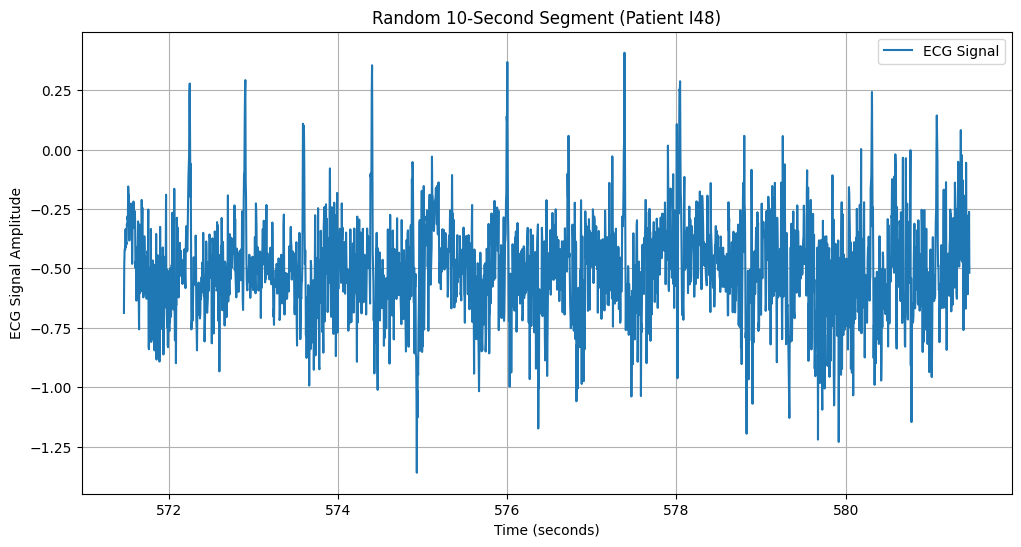

In [96]:
# Plot 1
# Your code here
sampling_rate = 257 
start = np.random.randint(0, len(signal) - 10*sampling_rate) 
end = start + 10*sampling_rate  
time_axis = np.arange(start, end) / sampling_rate 

plt.figure(figsize=(12, 6))
plt.plot(time_axis, signal[start:end], label='ECG Signal')
plt.title('Random 10-Second Segment (Patient I48)')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Signal Amplitude')
plt.grid(True)
plt.legend()
plt.show()

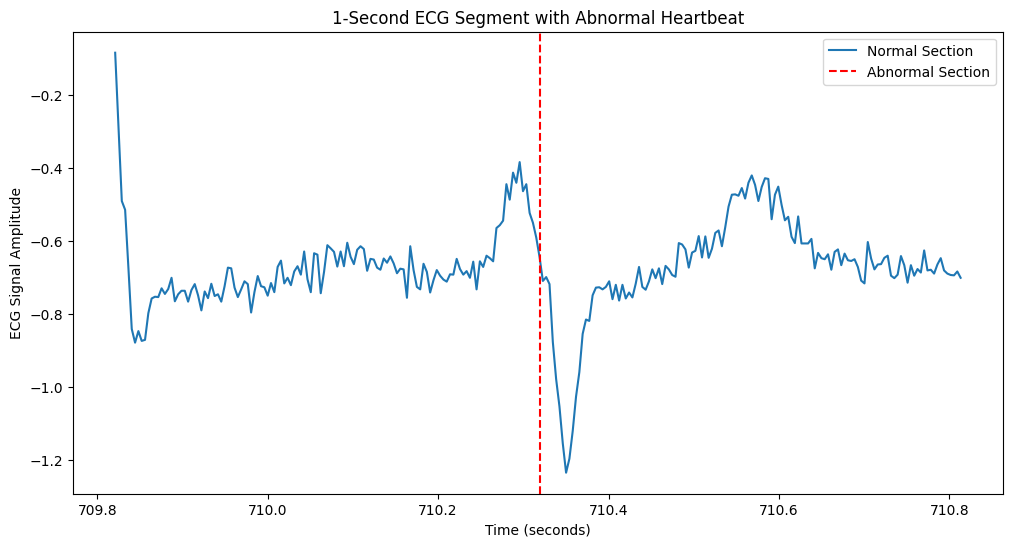

In [98]:
# Plot 2
# Your code here
abnormal_indices = [i for i, s in zip(index, symbol) if s in abnormal]
abnormal_index = abnormal_indices[len(abnormal_indices) // 2]
start_1s = abnormal_index - sampling_rate// 2
end_1s =  abnormal_index + sampling_rate // 2
time_1s = np.arange(start_1s, end_1s) / sampling_rate 
plt.figure(figsize=(12, 6))
plt.plot(time_1s, signal[start_1s:end_1s], label="Normal Section")
plt.axvline(x=abnormal_index / sampling_rate, color='r', linestyle='--', label="Abnormal Section")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Signal Amplitude")
plt.title("1-Second ECG Segment with Abnormal Heartbeat")
plt.legend()
plt.show()




## TASK 2: Data Preparation (10 points)
---

Training data and test data are typically represented by a matrix $X \in \mathbb{R}^{N\times D}$, where:  
- \( N \) represents the number of observations.  
- \( D \) represents the data dimension.  

In this task, each observation corresponds to a **1-second ECG sequence** containing a **normal** or **abnormal** symbol at the center (± 0.5 seconds).  
Since the sampling rate is \( f \), the data dimension \( D = f \).

Your objective is to construct the data matrix \( X \) and the corresponding label vector $y \in \mathbb{R}^{N\times 1}$, where:  
- **Label 0:** Normal  
- **Label 1:** Abnormal  

The final dataset should contain approximately **96000 data points**.

### **Requirements** (Failure to meet any requirement will result in **zero points** for this section):

1. **Abnormal Labeling:**  
   - All symbols in the abnormal list must be labeled as **1**.

3. **Patient Splitting:**  
   - The patients in the **training set** and **test set** must be **mutually exclusive**.  
   - The patient IDs for each set have been provided. Use them directly.

### **Tasks and Points Breakdown:**

1. **Implement `make_dataset` Function (4 points):**  
   - This function should generate the full dataset matrix \( X \) and label vector \( y \) based on the above requirements.

2. **Implement `build_XY` Function (4 points):**  
   - This function should process the ECG sequences and annotations to build \( X \) and \( y \) for both training and test sets.

3. **Validate Data Proportion (2 points):**  
   - Verify and report the proportion of normal and abnormal samples in your dataset (both train & test).

---

**Hint:**  
Ensure that each extracted 1-second segment is correctly centered around the annotated point. The sampling rate \( f \) determines the length of each segment.  


In [99]:
# training patient IDs
pts_train = [f'I{str(i).zfill(2)}' for i in range(1, 31)]
print(pts_train)

# testing patient IDs
pts_test = [f'I{str(i).zfill(2)}' for i in range(31, 41)]
print(pts_test)


['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I29', 'I30']
['I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39', 'I40']


In [101]:
def make_dataset(pts, num_sec, fs, abnormal):
    '''
    Create a dataset from ECG signals by extracting specific segments around heartbeats
    and labeling them based on the presence of abnormalities.

    Parameters:
    - pts: List of patient identifiers to load ECG files for processing.
    - num_sec (float): Number of seconds to include before and after each heartbeat in the extracted segment.
    - fs (int): Sampling frequency of the ECG signals, used to calculate the number of samples in each segment.
    - abnormal: List of abbreviations for abnormalities to look for in the ECG signals.

    Returns:
    - X_all (numpy.ndarray): Signal matrix with shape (nbeats, 2 * num_sec * fs).
    - Y_all (numpy.ndarray): Binary labels matrix with shape (nbeats, 1), indicating abnormality presence.
    '''
    # Your code here
    X_all = []
    Y_all = []
    num_samples = int(num_sec * fs )
    for pt in pts:
        signal, symbol, index = load_ECG_file(os.path.join(path_dataset, pt))
        for i, idx in enumerate(index):
            start = idx - num_samples
            end = idx + num_samples
            if start >= 0 and end < len(signal):
                segment = signal[start:end]
                X_all.append(segment)
                if symbol[i] in abnormal:
                    Y_all.append(1)
                else:
                    Y_all.append(0)
    X_all = np.array(X_all)
    Y_all = np.array(Y_all).reshape(-1, 1)
    return X_all, Y_all
   


def build_XY(p_signal, df_ann, num_cols, ab_idx, abnormal, num_sec, fs):
    '''
    Build the X (signal segments) and Y (abnormality labels) matrices for each beat.

    Parameters:
    - p_signal: The full ECG signal array.
    - df_ann: DataFrame containing filtered heartbeat annotations.
    - num_cols: The total number of samples per extracted segment.
    - ab_idx: Numpy array containing indices of abnormal beats.
    - abnormal: List of abnormal beat abbreviations.
    - num_sec: Number of seconds before and after each heartbeat for segment extraction.
    - fs: Sampling frequency (Hz).

    Returns:
    - X (numpy.ndarray): Extracted heartbeat signal segments.
    - Y (numpy.ndarray): Binary labels indicating abnormality presence.
    '''
    # Your code here
    X = []
    Y = []

    num_samples = int(num_sec * fs)
    for i, idx in enumerate(df_ann.index):
        if idx - num_samples >= 0 and idx + num_samples < len(p_signal):
            segment = p_signal[idx - num_samples:idx + num_samples ]
            X.append(segment)
            if df_ann.iloc[i]['symbol'] in abnormal:
                Y.append(1)
            else:
                Y.append(0)

    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)
    return X, Y
   

In [102]:
# Check the abnormal data / normal data ratio for training and testing set
# Your code here
def check_ratio(y_train, y_test):
    # Training set
    train_normal = np.sum(y_train == 0)
    train_abnormal = np.sum(y_train == 1)
    ratio_train = train_abnormal/train_normal
    print("Training set normal points:", train_normal )
    print("Training set abnormal points:",train_abnormal)
    print("Ratio:", ratio_train )
    # Test set
    test_normal = np.sum(y_test == 0)
    test_abnormal = np.sum(y_test == 1)
    ratio_test = test_abnormal/test_normal
    print("Testing set normal points:", test_normal )
    print("Testing set abnormal points:",test_abnormal)
    print("Ratio:", ratio_test )

num_sec = 0.5  
fs = 257       
X_train, y_train = make_dataset(pts_train, num_sec, fs, abnormal)
X_test, y_test = make_dataset(pts_test, num_sec, fs, abnormal)
check_ratio(y_train, y_test)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Training set normal points: 61705
Training set abnormal points: 9497
Ratio: 0.15390973178834777
Testing set normal points: 20914
Testing set abnormal points: 4892
Ratio: 0.23391029932102897
Shape of X_train: (71202, 256)
Shape of y_train: (71202, 1)


## Task 3: Feature Extraction (10 points)
---

In this task, you will use the **`scipy.signal`** library to extract features from the ECG signals for both the training and testing datasets.

### **Objective:**
- Perform **consecutive Fourier transforms** to compute the **spectrogram** of the ECG signals.  
- **Print the shape** of the extracted feature matrices for both **training** and **testing** datasets.

### **Key Points About Spectrograms:**
- A **spectrogram** visually represents the frequency content of a signal over time.  
- The spectrogram typically has three dimensions:
  - **Time axis:** Represents the time intervals of the signal.  
  - **Frequency axis:** Represents the frequencies present in the signal.  
  - **Amplitude/Intensity:** Represents the strength (amplitude) of a specific frequency at a specific time, commonly visualized as color intensity in spectrogram plots.

### **Task Requirements (10 points):**
1. **Implement Feature Extraction:**  
   - Use **`scipy.signal.spectrogram()`** or equivalent functions to extract spectrogram features from each ECG sequence.  
   - Apply **consecutive Fourier transforms** as part of the spectrogram generation process.

2. **Print Feature Shapes:**  
   - Output the **shape of the feature matrices** for both the training and testing datasets after feature extraction.  
   - Ensure the feature shapes match the expected input dimensions for downstream model training.

---


Examples of ECG spectrogram are shown below:

![ECG_spetrogram.jpg](https://d3i71xaburhd42.cloudfront.net/c86f76b6eeaa1ae92e5c96a68ca47d046fc01b2e/3-Figure2-1.png)

M. Salem, S. Taheri and J. Yuan, "ECG Arrhythmia Classification Using Transfer Learning from 2- Dimensional Deep CNN Features," 2018 IEEE Biomedical Circuits and Systems Conference (BioCAS), Cleveland, OH, USA, 2018, pp. 1-4, doi: 10.1109/BIOCAS.2018.8584808.

In [103]:
import numpy as np
from scipy import signal

def extract_features(X):
    '''
    Extracts time-frequency features from ECG segments using Short-Time Fourier Transform (STFT).

    Parameters:
    - X (numpy.ndarray): Input data matrix of shape (N, D), where
      N = number of segments, D = number of samples per segment.

    Returns:
    - X_features (numpy.ndarray): Feature matrix of shape (N, Time, Frequency).
    '''
    X_features = []
    for segment in X:
        f, t, Sxx = signal.spectrogram(segment, fs=257, nperseg=64, noverlap=32)
        X_features.append(Sxx.T)
    return np.array(X_features)

# Feature extraction for training and testing datasets
F_train = extract_features(X_train)
F_test = extract_features(X_test)

# Output the shape of extracted features
print(f"F_train shape: {F_train.shape}, F_test shape: {F_test.shape}")

F_train shape: (71202, 7, 33), F_test shape: (25806, 7, 33)


## Task 4: Distribution and Compensation for Imbalance (6 points)
---

### **Tasks and Points Breakdown:**

1. **Plot Label Distribution (6 points):**  
   - **Training Set Distribution (3 points):**  
     - Plot the **percentage distribution** of observations with **normal (label = 0)** and **abnormal (label = 1)** classes in the **training set**.  
     - Use **bar plots** or **pie charts** for clear visualization.  
   
   - **Testing Set Distribution (3 points):**  
     - Similarly, plot the **percentage distribution** of **normal** and **abnormal** observations in the **testing set**.

---

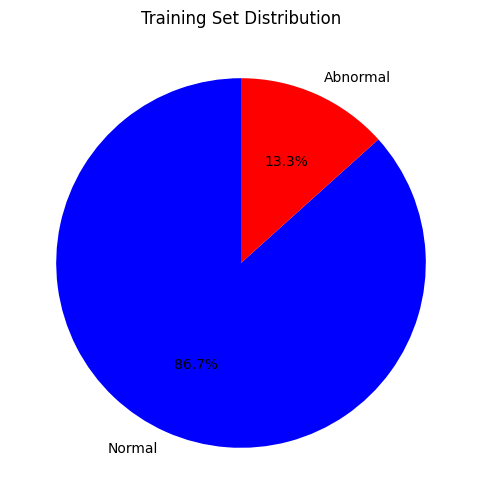

In [104]:
# Your code here
# Calculate class distribution for the training set
normal_train = np.sum(y_train == 0)
abnormal_train = np.sum(y_train == 1)
normal_percent_train = (normal_train / len(y_train)) * 100
abnormal_percent_train = (abnormal_train / len(y_train)) * 100
labels = ['Normal', 'Abnormal']
plt.figure(figsize=(8, 6))
plt.pie([normal_percent_train, abnormal_percent_train], labels=labels, colors=['blue', 'red'], autopct='%1.1f%%', startangle=90)
plt.title('Training Set Distribution')
plt.show()

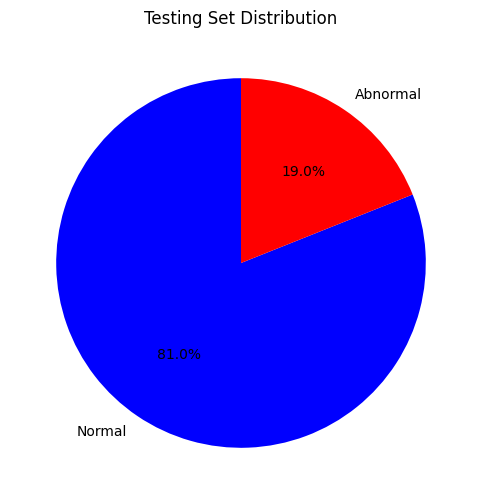

In [105]:
# Your code here
normal_test = np.sum(y_test == 0)
abnormal_test = np.sum(y_test == 1)
normal_percent_test = (normal_test / len(y_test)) * 100
abnormal_percent_test = (abnormal_test / len(y_test)) * 100
labels = ['Normal', 'Abnormal']
plt.figure(figsize=(8, 6))
plt.pie([normal_percent_test, abnormal_percent_test], labels=labels, colors=['blue', 'red'], autopct='%1.1f%%', startangle=90)
plt.title('Testing Set Distribution')
plt.show()

## Task 5: Distribution and Compensation for Imbalance (4 points)
---

**Dataset Imbalance Analysis and Compensation Strategy (4 points):**  
  - **Is the dataset balanced? (1 points)**  
     - Discuss whether the dataset shows class imbalance based on the plots.  
   
  - **Compensation Strategy - Weighted Loss (3 points):**  
    - If the dataset is imbalanced, describe how you would compensate for this imbalance using **weighted loss functions**, and create your own BCE weighted loss functions.  
      - **Explain your strategy**   
      - Provide reasoning for your choice, addressing:
      - How the weight adjustment improves learning for the minority class.  
      - Potential trade-offs between sensitivity and specificity.

### **Important Notes:**
**Be careful when you create your own BCE weighted loss functions, you are required to use this loss instead of nn.BCEWithLogitsLoss in your following task. If you use nn.BCEWithLogitsLoss, half of the points will be taken from each of your following task**.

---

Answer:The dataset is imbalanced because there is much more normal than abnormal.

In [106]:
def mybce(yhat, y, pos_weight=3, eps=1e-7):
    """
    Custom Binary Cross-Entropy (BCE) loss function with numerical stability and adjustable positive class weight.

    Parameters:
    - yhat (Tensor): Predicted probabilities (should be in the range [0, 1])
    - y (Tensor): Ground truth labels (0 or 1)
    - pos_weight (float): Weight for the positive class to handle class imbalance
    - eps (float): Small constant to prevent log(0) errors

    Returns:
    - loss (Tensor): Computed BCE loss
    """
    yhat = torch.clamp(yhat, eps, 1 - eps)
    loss = -torch.mean(pos_weight * y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))
    return loss

Answer:  Weighted BCE loss reduces class imbalance by assigning higher weights to the minority class, improving sensitivity for detecting abnormal heartbeats. However, it might cause the model to prioritize the minority class over the majority class, leading to more false positive cases.

# Implementing Neural Networks

In the following tasks, you will implement various neural network architectures discussed during the lectures.  
You will train your models using the **ECG data** you have processed and explored in the previous tasks and report the performance metrics for each model.

---

### **Important Notes:**

- **Task 6:**  
  - You must **only use** `torch.nn.Sequential` to build your neural network.  
  - **Points will be deducted** if you fail to follow this requirement, even if your model is otherwise correct.

- **Task 7:**  
  - You must **only use** `torch.nn.Module` to define your neural network.  
  - Again, **points will be deducted** for not adhering to this instruction, regardless of model correctness.

---

## TASK 6 LSTM (20 points total)
---
 Now, we are going to train a classifier to detect abnormal ECG cycles. We will train a simplified version of the LSTM-based network described in one of the [previously cited papers](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA).

### **Important Notes:**

- Printing loss function and accuracy while training to make sure your model works.

- You need to add a flattening layer after LSTM layer (and before linear layer).

- The output of LSTM in pytorch lib have a tuple output, add the following GetLSTMOutput after your layer

- You should use the loss function you implemented above

---

In [107]:
# Adapt your input to tensor
F_train = torch.from_numpy(F_train).float()
F_test= torch.from_numpy(F_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
class GetLSTMOutput(nn.Module):
    def forward(self, x):
        out,_ = x
        return out

### Task 6.1: Single-Layer Bidirectional LSTM using `torch.nn.Sequential` (8 points)
---

In this task, you will implement a **single-layer Bidirectional LSTM** model in **PyTorch** using only **`torch.nn.Sequential`**.  
The architecture should include:  
- A **Bidirectional LSTM layer**.  
- A **Linear layer** with **Sigmoid activation**.  
- The **number of output units** in the final layer should be **1**.

### **Tasks and Points Breakdown:**

1. **Create Tensor Datasets & Dataloader (2 points):**  
   - Convert the preprocessed training and testing data into **`TensorDataset`** objects.  
   - Use **`DataLoader`** to create iterable batches for training and testing.  
   - Ensure proper **batch size** and **shuffle** parameters are set.

2. **Create the BiLSTM Model using `nn.Sequential` (6 points):**  
   - Build a **single-layer Bidirectional LSTM** model using **only** `torch.nn.Sequential`.  
   - The LSTM layer should be **bidirectional**, followed by:  
     - A **Linear layer**.  
     - A **Sigmoid activation** function.  
   - The **output layer** should have **1 unit** to represent the binary classification output.

### **Important Notes:**  
- **`torch.nn.Module` usage is strictly prohibited** for this task.  
- **Points will be deducted** if `torch.nn.Module` is used, **even if the model is correct**.  
- Ensure the input and output dimensions **match the data structure** and **model requirements**.

---

In [108]:
# Create TensorDatasets
# Your code here
train_dataset = TensorDataset(F_train, y_train)
test_dataset = TensorDataset(F_test, y_test)

# Create DataLoaders
# Your code here
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [109]:
# Define hyperparameters
# Your code here
input_size = F_train.shape[2]  
hidden_size = 64  
num_layers = 1  
bidirectional = True  
output_size = 1 
sequence_length = F_train.shape[1]

model = nn.Sequential(
    nn.LSTM(
        input_size=input_size,  
        hidden_size=hidden_size, 
        num_layers=num_layers, 
        bidirectional=bidirectional,  
        batch_first=True  
    ),
    GetLSTMOutput(),
    nn.Flatten(start_dim=1), 
    nn.Linear(hidden_size * 2 * sequence_length, output_size),  
    nn.Sigmoid()
)


### Task 6.2: Model, Loss Function, and Optimizer Definition (2 points)
---

In this task, you will define the following components for your **Bidirectional LSTM** model:

### **Important Notes:**  
- Ensure **`pos_weight`** in the loss function reflects the class distribution from Task 5.  
- **GPU acceleration** should be utilized (`cuda`) if available for faster training.  
- **Points will be deducted** if the loss function does not match the one specified in **Task 5**.

---

In [110]:
# Define loss function and optimizer.
# Your code here
def weighted_bce_loss(yhat, y):
    return mybce(yhat, y, pos_weight=3)
criterion = weighted_bce_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda")
model = model.to(device)
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)

### Task 6.3: Train and Test Your Model (10 points)
---

In this task, you will train and evaluate the **Bidirectional LSTM** model you defined in **Task 6.2**.  

### **Tasks and Points Breakdown:**

1. **Training Process (5 points):**  
   - Train the model for a specified number of **epochs**.  
   - **Print the loss and accuracy** after each epoch to monitor the training process.  
   - If you encounter **RAM overflow**, consider using **mini-batches** during training by adjusting the **`DataLoader`** batch size.

2. **Evaluation Process (5 points):**  
   - After training, report the **final accuracy** on the **test set**.  
   - Use appropriate evaluation metrics (e.g., **accuracy**, **F1-score**) for binary classification.

### **Important Notes:**  
- Use **`torch.no_grad()`** during testing to avoid tracking gradients.  
- Ensure the **batch size** is optimized to prevent **RAM overflow** in Colab sessions.  
- Evaluate the model on the **test set** only after the training is complete.  
- Print statements should clearly show **epoch-wise loss and accuracy**.

---

In [116]:
# Train the model
# Your code here
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  
    losses = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = to_device(data, device), to_device(target, device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()
        predicted = (output > 0.5).float() 
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = losses / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/10], Loss: 0.236, Accuracy: 96.16%
Epoch [2/10], Loss: 0.229, Accuracy: 96.28%
Epoch [3/10], Loss: 0.222, Accuracy: 96.40%
Epoch [4/10], Loss: 0.216, Accuracy: 96.48%
Epoch [5/10], Loss: 0.212, Accuracy: 96.50%
Epoch [6/10], Loss: 0.206, Accuracy: 96.55%
Epoch [7/10], Loss: 0.205, Accuracy: 96.61%
Epoch [8/10], Loss: 0.202, Accuracy: 96.70%
Epoch [9/10], Loss: 0.197, Accuracy: 96.74%
Epoch [10/10], Loss: 0.195, Accuracy: 96.69%


In [117]:
# Evaluate the model on the test data, print test accuracy and F1-score
# Your code here
from sklearn.metrics import accuracy_score, f1_score
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = to_device(data, device), to_device(target, device)
        output = model(data)
        predicted = (output > 0.5).float()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(target.cpu().numpy())
accuracy = accuracy_score(targets, predictions)
f1 = f1_score(targets, predictions )
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test F1-Score: {f1:.3f}")

Test Accuracy: 85.65%
Test F1-Score: 0.617


## TASK 7: 1-D CNNs (25 points total)
---

In this task, you will implement a **1D Convolutional Neural Network (1D CNN)** using **`torch.nn.Module`**.  
The network will use **ReLU activation** after the convolutional layer, followed by a **flattening layer**, and a **linear layer** with **Sigmoid activation** for binary classification.

### **Task Requirements:**

1. **Model Architecture:**
   - Use **`torch.nn.Conv1d`** for the convolutional layer.  
   - Apply **ReLU activation** after the convolutional layer.  
   - Add a **flattening layer** immediately after the CNN layer (before the linear layer).  
   - Use a **linear layer** with **Sigmoid activation** as the final layer. The output should have **1 unit** for binary classification.

2. **Loss Function:**
   - Use the **weighted loss function** you implemented in the previous tasks.

3. **Training Process:**
   - Print the **loss** and **accuracy** for each epoch during training to confirm the model is learning properly.

4. **Evaluation Process:**
   - Report the **final accuracy** on **test set** after training is complete.

### **Important Notes:**  
- **Flattening layer** placement: directly after the convolutional layer and before the linear layer.  
- Use **Sigmoid** activation in the final layer to handle binary classification.  
- **GPU acceleration** (`cuda`) is recommended if available.  
- The loss function must match the one used in previous tasks (**points will be deducted** otherwise).

---

### Task 7.1: Deep 1-D CNN Model (10 points)
---

In this task, you will implement a **deep 1-D Convolutional Neural Network (CNN)** in **PyTorch** by **subclassing `torch.nn.Module`**.  
The network should have **multiple CNN layers**, followed by one or more **linear layers** with various **activation functions**.  
The **final output layer** must contain **1 unit** for binary classification.

### **Task Requirements:**

1. **Model Architecture:**
   - Use **multiple `torch.nn.Conv1d` layers** (more than one convolutional layer).  
   - Apply **ReLU activation** after each convolutional layer.  
   - Add appropriate **pooling layers** (e.g., `nn.MaxPool1d`) for dimensionality reduction.  
   - **Flatten** the output from the convolutional layers before passing it to the linear layers.  
   - Use **one or several fully connected (linear) layers** with **different activation functions** (e.g., ReLU, Tanh).  
   - The **final output layer** should have:
     - **1 output unit** for binary classification.  
     - **Sigmoid activation** for probability output.

2. **Implementation Restrictions:**
   - **You must subclass `torch.nn.Module`.**  
   - **Do NOT use `torch.nn.Sequential`** anywhere in the implementation (**points will be deducted** if used).

### **Important Notes:**
- Ensure that **input dimensions** match across layers after convolutions and pooling.  
- The **final output** should represent a **binary classification probability** (between 0 and 1).  
- **GPU acceleration** (`cuda`) should be used if available for efficient training.

---

In [119]:
# Create the BiLSTM model using nn.Module
class ConvModel(nn.Module):
    def __init__(self,input_channels=7, num_classes=1, input_length=32):
        # Your code here
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flattened_size = 128 * (input_length // 8)  
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))      
        return x

### Task 7.2: Model, Loss Function, and Optimizer Definition (2 points)
---

In this task, you will define the following components for your **deep 1-D CNN model**:

### **Important Notes:**  
- Ensure **`pos_weight`** in the loss function reflects the class distribution from Task 5.  
- **GPU acceleration** should be utilized (`cuda`) if available for faster training.  
- **Points will be deducted** if the loss function does not match the one specified in **Task 5**.

---

In [120]:
# Define model, loss function and optimizer
# Your code here
input_length = F_train.shape[2] 
model = ConvModel(input_channels=7, num_classes=1, input_length=input_length)
pos_weight = 3
criterion = weighted_bce_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda")
model = model.to(device)
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)

### Task 7.3: Train and Test Your Model (10 points)
---

In this task, you will **train** and **evaluate** the **deep 1-D CNN model** defined in **Task 7.2**.

### **Tasks and Points Breakdown:**

1. **Training Process (5 points):**  
   - Train the model for a specified number of **epochs**.  
   - **Plot the loss and accuracy** after each training epoch to visualize the training process.  
   - Ensure proper **mini-batch training** to avoid **RAM overflow**.

2. **Evaluation Process (5 points):**  
   - After training, **report the final accuracy** on the **test set**.  
   - Use suitable performance metrics such as **accuracy** and optionally **F1-score** for binary classification.

### **Important Notes:**  
- Use **`torch.no_grad()`** during testing to prevent gradient computations.  
- Plots should display:
  - **Loss vs. Epochs**  
  - **Accuracy vs. Epochs**  
- Ensure **consistent batch sizes** and **GPU usage** (`cuda`) for faster training.

---

In [121]:
# Your code here
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  
    losses = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = to_device(data, device), to_device(target, device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()
        predicted = (output > 0.5).float() 
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = losses / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/10], Loss: 0.544, Accuracy: 90.72%
Epoch [2/10], Loss: 0.242, Accuracy: 96.05%
Epoch [3/10], Loss: 0.227, Accuracy: 96.30%
Epoch [4/10], Loss: 0.224, Accuracy: 96.43%
Epoch [5/10], Loss: 0.220, Accuracy: 96.28%
Epoch [6/10], Loss: 0.210, Accuracy: 96.52%
Epoch [7/10], Loss: 0.213, Accuracy: 96.58%
Epoch [8/10], Loss: 0.211, Accuracy: 96.64%
Epoch [9/10], Loss: 0.205, Accuracy: 96.62%
Epoch [10/10], Loss: 0.201, Accuracy: 96.59%


In [124]:
# Your code here
from sklearn.metrics import accuracy_score, f1_score
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = to_device(data, device), to_device(target, device)
        output = model(data)
        predicted = (output > 0.5).float()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(target.cpu().numpy())
accuracy = accuracy_score(targets, predictions)
f1 = f1_score(targets, predictions )
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test F1-Score: {f1:.3f}")

Test Accuracy: 88.90%
Test F1-Score: 0.675


### Task 7.4 (3 points)

---

 Comment the difference between your CNN and LSTM models.

---

Answer: The CNN model processes ECG signals using convolutional layers to extract local features, having slower training times and higher accuracy on test accuracy. In contrast, the LSTM model have faster training times and higher accuracy on trained data.

## Task 8: AlexNet Implementation (15 points total)
---

In this task, you will implement **AlexNet**, a deep convolutional neural network (CNN) architecture proposed by **Alex Krizhevsky**, **Ilya Sutskever**, and **Geoffrey Hinton**.  
AlexNet achieved a major breakthrough in computer vision by winning the **ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012**. It introduced innovations such as **ReLU activation**, **dropout regularization**, and **deep convolutional layers**.

### **Important Notes:**
- Use **`torch.nn.Sequential`** to subclass the model.  
- Ensure the model output is compatible with **binary classification** (i.e., final output dimension = 1).  
- Consider **GPU acceleration** (`cuda`) for faster training if available.

---

### Task 8.1 (5 points)

---

 Establish and train a AlexNet which is similiar to the AlexNet of the paper: ["Classification of ECG signal using FFT based improved Alexnet classifier"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9514660/) The structure of Alex Net is shown below.

---

![AlexNet](https://www.ncbi.nlm.nih.gov/corecgi/tileshop/tileshop.fcgi?p=PMC3&id=166618&s=150&r=1&c=1)

In [ ]:
# Create the BiLSTM model using nn.Sequential
# Your code here

In [ ]:
# Define loss function and optimizer
# Your code here

### Task 8.2: Train and Test Your AlexNet Model (10 points)
---

### **Tasks and Points Breakdown:**

1. **Training Process (5 points):**  
   - Train the **AlexNet-based ECG classifier** for a sufficient number of **epochs**.  
   - **Plot the loss and accuracy** per epoch to monitor the training process.  
   - If RAM overflow occurs, consider **using mini-batches**.

2. **Evaluation Process (5 points):**  
   - After training, **report the final accuracy** on both the **training set** and **test set**.  
   - Use appropriate evaluation metrics, such as **accuracy** and optionally **F1-score**, to assess classification performance.

### **Important Notes:**
- Use **`torch.no_grad()`** during testing to avoid gradient tracking.  
- **Plot two graphs**:
  - **Loss vs. Epochs**  
  - **Accuracy vs. Epochs**  
- Ensure that **GPU acceleration (`cuda`) is enabled** if available.  

---

In [ ]:
# Your code here

## Bonus Task (20 points)
---

In this task, you are required to implement a **customized LSTM model** using **PyTorch**.  
- **`nn.Module`** is **allowed**, but **`nn.LSTM` is strictly forbidden**.  
- The goal is to replicate the results from **Task 6**.  
- Due to computational resource constraints, you are required to train the model for only **5 epochs**.  
- You can use **`nn.BCEWithLogitsLoss`**.

### **Task Requirements:**

1. **Training Process (10 points):**  
   - **Print the loss and accuracy** after each training epoch.  
   - Ensure the training loop displays clear and well-formatted output for each epoch.

2. **Evaluation Process (10 points):**  
   - **Report the final accuracy** on both the **training set** and the **test set** after 5 epochs of training.  
   - Ensure evaluation is performed using **`torch.no_grad()`** to prevent gradient tracking.

### **Important Notes:**  
- The **custom LSTM** should be built **from scratch**, defining your own LSTM cells (input, forget, output gates, and cell state updates).  
- **GPU acceleration** (`cuda`) should be utilized if available.  
- Ensure proper **input and output dimensions** for binary classification.  
- **Mini-batch training** is recommended to prevent **RAM overflow**.

---


In [ ]:
class CustomBiLSTM(nn.Module):
    """
    Custom Bidirectional LSTM model.

    Inputs:
        - input_size (int): Dimension of the input features.
        - hidden_size (int): Dimension of the LSTM hidden layer.
        - output_size (int): Dimension of the output layer.
        - seq_length (int): Length of the input sequence.

    Outputs:
        - out (Tensor): Final output tensor with shape (batch_size, output_size).
    """
    def __init__(self, input_size, hidden_size, output_size, seq_length):
    # Your code here

    def lstm_cell(self, x, h_prev, c_prev, W_f, W_i, W_c, W_o):
        """
        LSTM cell computation for a single time step.

        Inputs:
            - x (Tensor): Input at the current time step.
            - h_prev (Tensor): Hidden state from the previous time step.
            - c_prev (Tensor): Cell state from the previous time step.
            - W_f, W_i, W_c, W_o (nn.Linear): Weight matrices for forget, input, cell, and output gates.

        Outputs:
            - h_t (Tensor): Updated hidden state.
            - c_t (Tensor): Updated cell state.
        """
        # Your code here

    def _forward_lstm(self, x):
        """
        Forward pass through the bidirectional LSTM layer.

        Inputs:
            - x (Tensor): Input tensor with shape (batch_size, seq_length, input_size).

        Outputs:
            - outputs (Tensor): Concatenated forward and backward hidden states.
        """
        # Your code here

        # Forward direction
        # Your code here

        # Backward direction
        # Your code here

        # Concatenate forward and backward outputs
        # Your code here

    def forward(self, x):
        """
        Forward pass of the entire model.

        Inputs:
            - x (Tensor): Input tensor with shape (batch_size, seq_length, input_size).

        Outputs:
            - out (Tensor): Output tensor with shape (batch_size, output_size).
        """
        # Your code here


# Parameter definitions
# Your code here

# Print training batch shape for verification
# Your code here

# Train the model
# Your code here

# Test the model
# Your code here

**You are ready to submit in Canvas!**

3 easy steps to submit your lab:

1. Download your file from Rockfish to your local PC by click File -> Save as -> Show Local -> Save. Please make your file name as: Lab4_FirstName_LastName_JHID.ipynb
2. Export the notebook to a PDF file with all the outputs by click ... -> Export -> PDF -> Show Local -> Save.Please make your file name as: Lab4_FirstName_LastName_JHID.pdf
3. Upload the "ipynb" adn "pdf" file obtained from Step (1) to Canvas. If its too big, zip it before uploading.

That's it!